In [65]:
import pandas as pd
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [66]:
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

train_df["split"] = "train"
val_df["split"] = "validation"
test_df["split"] = "test"

df = pd.concat([train_df, val_df, test_df], ignore_index=True)

In [67]:
def parse_and_pad_column(col, maxlen=200):
    vectors = df[col].apply(lambda x: np.array(eval(x)))
    padded = pad_sequences(vectors, maxlen=maxlen, padding='post', dtype='float32')
    return padded

max_len = 200

x1 = parse_and_pad_column("code1_vecMark", maxlen=max_len)
x2 = parse_and_pad_column("code2_vecMark", maxlen=max_len)
y = df["result"].values
splits = df["split"]

x1 = np.expand_dims(x1, axis=-1)
x2 = np.expand_dims(x2, axis=-1)

In [68]:
x1_train = x1[splits == "train"]
x2_train = x2[splits == "train"]
y_train = y[splits == "train"]

x1_val = x1[splits == "validation"]
x2_val = x2[splits == "validation"]
y_val = y[splits == "validation"]

x1_test = x1[splits == "test"]
x2_test = x2[splits == "test"]
y_test = y[splits == "test"]

In [69]:
from tensorflow.keras.optimizers import Adam

def build_branch(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv1D(128, 5, activation='relu', padding='same')(input_layer)
    x = GlobalMaxPooling1D()(x)
    return input_layer, x

input_shape = (max_len, 1)
input1, out1 = build_branch(input_shape)
input2, out2 = build_branch(input_shape)

merged = Concatenate()([out1, out2])
x = Dense(128, activation='relu')(merged)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 conv1d_16 (Conv1D)          (None, 200, 128)             768       ['input_17[0][0]']            
                                                                                                  
 conv1d_17 (Conv1D)          (None, 200, 128)             768       ['input_18[0][0]']            
                                                                                            

In [70]:
model.fit(
    [x1_train, x2_train], y_train,
    validation_data=([x1_val, x2_val], y_val),
    epochs=100,
    batch_size=32
)


Epoch 1/100
30/30 [==============================] - 1s 8ms/step - loss: 0.6890 - accuracy: 0.5452 - val_loss: 0.7675 - val_accuracy: 0.3153
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.5515 - val_loss: 0.7563 - val_accuracy: 0.3153
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.5515 - val_loss: 0.7363 - val_accuracy: 0.3153
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.5515 - val_loss: 0.7471 - val_accuracy: 0.3153
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5630 - val_loss: 0.6892 - val_accuracy: 0.6847
Epoch 6/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.5410 - val_loss: 0.7479 - val_accuracy: 0.3153
Epoch 7/100
30/30 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.5504 - val_loss: 0.7433 - val_accuracy: 0.3153
Epoch 8/100
3

In [71]:
loss, accuracy = model.evaluate([x1_test, x2_test], y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

10/10 [==============================] - 0s 1ms/step - loss: 0.7582 - accuracy: 0.5000

Test Accuracy: 0.5000


10/10 [==============================] - 0s 1ms/step


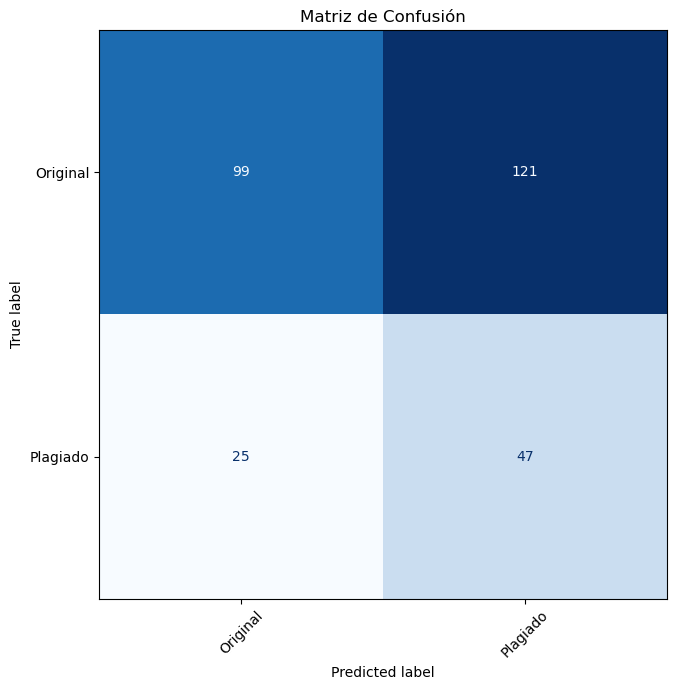


Reporte de clasificación:

              precision    recall  f1-score   support

    Original       0.80      0.45      0.58       220
    Plagiado       0.28      0.65      0.39        72

    accuracy                           0.50       292
   macro avg       0.54      0.55      0.48       292
weighted avg       0.67      0.50      0.53       292



In [72]:
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


y_pred = (model.predict([x1_test, x2_test]) > 0.5).astype(int).flatten()
labels = ["Original", "Plagiado"]

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(7, 7))
disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
plt.xticks(rotation=45)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()

print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred, target_names=labels))